In [32]:
%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [34]:
import sys
sys.path.append("..")

In [35]:
%matplotlib inline
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from glob import glob
from PIL import Image
import matplotlib.image as mpimg
import torch

In [36]:
from src.data.datasplit import DataSplit
from src.data.dataload import FaceToBMIDataset
from src.config import cfg

In [37]:
raw_data_path =  cfg.raw_data_path
full_annotation_name = cfg.full_annotation_name
data_path = cfg.data_path
batch_size = cfg.batch_size
female_annotation_name = cfg.female_annotation_name
male_annotation_name = cfg.male_annotation_name
image_dir = cfg.image_dir

In [38]:
annotation_df = pd.read_csv(raw_data_path+'annotation.csv')
annotation_df.head()
print("Annotation data: ",len(annotation_df))

Annotation data:  1026


In [39]:
all_files = glob(raw_data_path+"images/*")
all_jpgs = sorted([img for img in all_files if ".jpg" in img or ".jpeg" in img or "JPG" in img])
print("Total {} photos ".format(len(all_jpgs)))

Total 1026 photos 


In [40]:
id_path = [image for image in all_jpgs ]
image_df = pd.DataFrame(id_path, columns=['path'])

In [41]:
full_df = image_df.merge(annotation_df, left_index=True, right_index=True)
full_df = full_df.drop(['image'], axis=1)
full_df.to_csv(full_annotation_name, index=False, header=True)
full_df.head()

,path,height,weight,BMI
0,../data/raw/images/f_001.jpg,1.55,61.0,25.390219
1,../data/raw/images/f_002.jpg,1.76,85.0,27.440599
2,../data/raw/images/f_003.jpg,1.78,56.0,17.674536
3,../data/raw/images/f_004.jpg,1.63,63.0,23.711845
4,../data/raw/images/f_005.jpg,1.76,54.0,17.432851


In [42]:
female_df = full_df.iloc[:513,:]
male_df = full_df.iloc[513:,:]
female_df.to_csv(female_annotation_name, index=False, header=True)
male_df.to_csv(male_annotation_name, index=False, header=True)

Image path: ../data/raw/images/f_066.jpg
Values shape: (1, 3)
height: 1.77 m, weight: 55.0 kg, bmi: 17.55561939


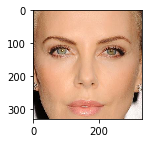

In [43]:
#Get a sample entry
n = 65
image_path = full_df.iloc[n, 0]
values = np.asarray(full_df.iloc[n, 1:])
values = values.astype('float').reshape(-1, 3)

print('Image path: {}'.format(image_path))
print('Values shape: {}'.format(values.shape))
print('height: {} m, weight: {} kg, bmi: {}'.format(*values[:, 0], *values[:, 1], *values[:, 2]))
fig = plt.figure(figsize=(2,2))
image = mpimg.imread(image_path)
plt.imshow(image);

In [44]:
total_dataset = FaceToBMIDataset(csv_file=full_annotation_name, image_dir=image_dir)
female_dataset = FaceToBMIDataset(csv_file=female_annotation_name, image_dir=image_dir)
male_dataset = FaceToBMIDataset(csv_file=male_annotation_name, image_dir=image_dir)

In [45]:
torch.save(female_dataset, "../data/processed/female_dataset.pt")
torch.save(male_dataset, "../data/processed/male_dataset.pt")
torch.save(total_dataset, "../data/processed/total_dataset.pt")

In [46]:
split = DataSplit(male_dataset, shuffle=True)
train_loader, val_loader, test_loader = split.get_split(batch_size=batch_size)

# If running on Colab change number of workers
#train_loader, val_loader, test_loader = split.get_split(batch_size=batch_size, num_workers=4)

print("Total batches", len(male_dataset)//batch_size)
print("Train batches", len(train_loader))
print("Validation batches", len(val_loader))
print("Test batches", len(test_loader))

Total batches 32
Train batches 24
Validation batches 3
Test batches 7


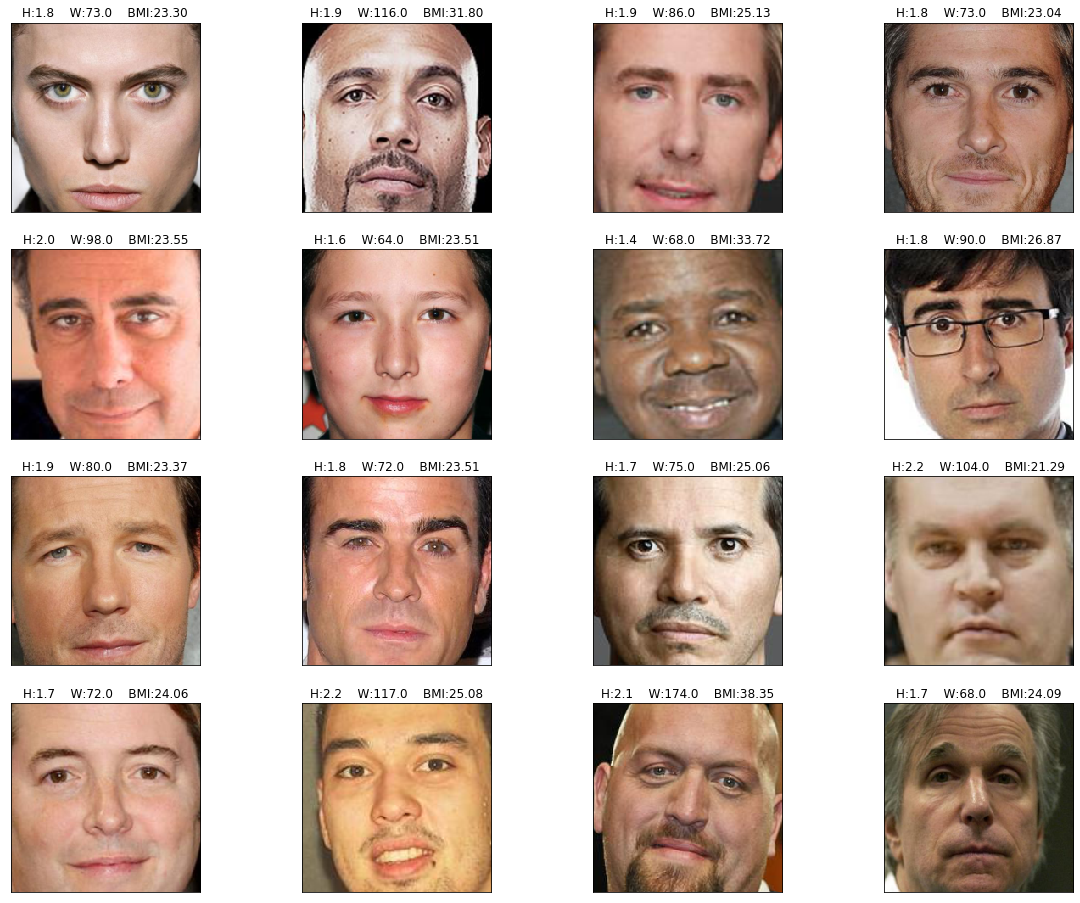

In [47]:
test_loader.dataset.set_transform("test")
def imshow(img):
    plt.imshow(np.transpose(img, (1,2,0)))

# obtain one batch of training images
dataiter = iter(test_loader)
images, height, weight, bmi = dataiter.next()
images = images.numpy() # convert images to numpy for display

# plot the images in the batch, along with the corresponding labels
fig = plt.figure(figsize=(20, cfg.batch_size))
# display 16 images
for idx in np.arange(cfg.batch_size):
    ax = fig.add_subplot(4, cfg.batch_size/4, idx+1, xticks=[], yticks=[])
    imshow(images[idx])
    ax.set_title("H:{:.1f}    W:{:.1f}    BMI:{:.2f}".format(height[idx,:].item(), weight[idx,:].item(), bmi[idx,:].item()))

In [48]:
images, height, weight, bmi = next(iter(test_loader))
print(images.shape)
print(height.shape)
print(weight.shape)
print(bmi.shape)

torch.Size([16, 3, 224, 224])
torch.Size([16, 1])
torch.Size([16, 1])
torch.Size([16, 1])
